# Bigwarp .zarr to OME TIFF

## Setting up a conda environment

```bash
conda env create -f environment.yml
conda activate zarr-ometiff
```

## Open Bigwarp .zarr

In [1]:
from pathlib import Path
import zarr
from typing import Tuple

In [2]:
zarr_path = r'D:\Frank\BigWarp-Troubleshooting\warped.zarr'
assert Path.exists(Path(zarr_path))

In [3]:
root = zarr.open(zarr_path, 'r')

In [4]:
root.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='warped', nodes=(Node(disabled=True,…

In [5]:
# Get the name of the first group in the zarr
# (in the case of bigwarp zarr there is only one)
group_key = list(root)[0]
group = root[group_key]
group

<zarr.hierarchy.Group '/warped' read-only>

In [6]:
channel_group_names = [item[1].name for item in group.items()]
channel_group_names

['/warped/cycle2.ome.tif-DAPI',
 '/warped/cycle2.ome.tif-Opal_520',
 '/warped/cycle2.ome.tif-Opal_570',
 '/warped/cycle2.ome.tif-Opal_690',
 '/warped/cycle2.ome.tif-Opal_780',
 '/warped/cycle2.ome.tif-Sample_AF']

In [7]:
# The group names look like this: '/warped/cycle2.ome.tif-DAPI'
# we extract the channel name as the part after the '-'.
channel_names = [name.split('-')[1] for name in channel_group_names]
channel_names

['DAPI', 'Opal_520', 'Opal_570', 'Opal_690', 'Opal_780', 'Sample_AF']

In [8]:
def _zarr_image_get_pixelsize_um(root, group_name) -> Tuple[float, float]:
    # As an example a transform attribute for an image channel in a Bigwarp zarr:
    # {'axes': ['y', 'x'], 'scale': [0.0002495152876362007, 0.0002495152876362007, 0.001], 'translate': [0.0, 0.0, 0.0], 'units': ['mm', 'mm']}
    # It is inconsistent because sometimes it specifies three dimensions, and sometimes two.
    transform = root[group_name].attrs['transform']
    print(f'Image transform {transform}')

    assert transform['axes'] == ['y', 'x']
    assert transform['translate'] == [0.0, 0.0, 0.0]
    assert transform['units'] == ['mm', 'mm']

    scale = transform['scale']
    assert len(scale) == 3  # the 3rd dimensions is probably a default z-plane distance of 1 micron

    pixel_size_y_um = scale[0] * 1000.0 
    pixel_size_x_um = scale[1] * 1000.0

    return (pixel_size_y_um, pixel_size_x_um)

In [9]:
pixel_size_um: Tuple[float, float] = _zarr_image_get_pixelsize_um(root, '/warped/cycle2.ome.tif-DAPI')

Image transform {'axes': ['y', 'x'], 'scale': [0.0002495152876362007, 0.0002495152876362007, 0.001], 'translate': [0.0, 0.0, 0.0], 'units': ['mm', 'mm']}


## Visual exploration of the zarr

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Read the first channel as an example
img = root[channel_group_names[0]]
img

<zarr.core.Array '/warped/cycle2.ome.tif-DAPI' (63360, 69120) uint8 read-only>

In [12]:
# The physical pixel size can be recovered from the zarr attributes dictionary
# associated with the zarr group holding the (single channel) image.
img.attrs['transform']

{'axes': ['y', 'x'],
 'scale': [0.0002495152876362007, 0.0002495152876362007, 0.001],
 'translate': [0.0, 0.0, 0.0],
 'units': ['mm', 'mm']}

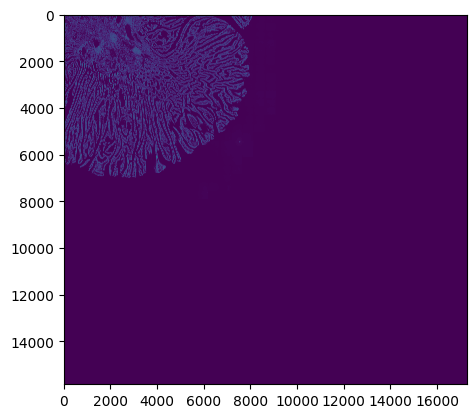

In [13]:
plt.imshow(img[::4,::4])

## Read full image stack

In [14]:
import dask.array as da

In [15]:
das = [da.array(root[channel_group_name])
       for channel_group_name
       in channel_group_names]
das

[dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(11264, 11264), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(11264, 11264), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(11264, 11264), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(11264, 11264), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(11264, 11264), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(11264, 11264), chunktype=numpy.ndarray>]

In [16]:
# Merge 2D daskarrays to a single 3D array
img_stack = da.stack(das)  # shape is (channels, y, x)
img_stack

dask.array<stack, shape=(6, 63360, 69120), dtype=uint8, chunksize=(1, 11264, 11264), chunktype=numpy.ndarray>

In [17]:
print(type(img_stack))
print(img_stack.dtype)
print(img_stack.shape)

<class 'dask.array.core.Array'>
uint8
(6, 63360, 69120)


## Save as OME TIFF

In [18]:
from skimage.transform import downscale_local_mean
from typing import List, Optional, Tuple, Iterator
import numpy as np
import tifffile
import math

In [19]:
def write_pyramidal_ome_tiff(img_stack: da.Array,                # dask array image stack of shape (channels, y, x)
                             pyramid_filename: str,
                             channel_names: Optional[List[str]],
                             pixel_size_um: Optional[Tuple[float, float]],        # pixel size in microns, or None
                             compression: Optional[str],         # 'zlib' or None
                             tile_size: int,                     # tile size (in pixels) in output OME TIFF file
                             max_levels: int,
                             downsample_method: str) -> None:    # downsample method = 'box' (better quality, slower) or 'nearest neighbor' (faster, poorer quality)

    num_pyramid_levels: int = max_levels  # CHECKME: do we need to clip this value in case we would end up with <= 1 pixel images in the pyramid?

    ome_metadata = _make_ome_metadata(img_stack, channel_names, pixel_size_um)

    tile_sizes = (tile_size, tile_size)

    options = dict(tile=tile_sizes,
                   photometric='minisblack',
                   compression=compression,
                   metadata=ome_metadata,
                   software=_creator())
    
    num_channels, image_height, image_width = img_stack.shape

    # Create output folder if it does not exist yet.
    Path(pyramid_filename).parent.mkdir(parents=True, exist_ok=True)

    print(f'Writing pyramidal OME TIFF file {pyramid_filename} (compression: {options["compression"]})')
    with tifffile.TiffWriter(pyramid_filename, ome=True, bigtiff=True) as tif:
        
        # Write full resolution image
        print(f'Writing level 0: {image_width} x {image_height} px')
        downsample_factor = 1
        tif.write(data=_tiles_generator(img_stack, tile_sizes, downsample_factor, downsample_method),
                  shape=(num_channels, image_height, image_width, 1),
                  dtype=img_stack.dtype,
                  subifds=num_pyramid_levels-1,
                  **options)

        # Save downsampled pyramid images to the subifds
        for level in range(1, num_pyramid_levels):
            downsampled_data_shape = math.ceil(image_height / (2**level)), math.ceil(image_width / (2**level))
            print(f'Writing level {level}: {downsampled_data_shape[1]} x {downsampled_data_shape[0]} px')
            downsample_factor = 2**level
            tif.write(data=_tiles_generator(img_stack, tile_sizes, downsample_factor, downsample_method), 
                      shape=(num_channels, downsampled_data_shape[0], downsampled_data_shape[1], 1),
                      dtype=img_stack.dtype,
                      subfiletype=1,
                      **options)


def _tiles_generator(img_stack: da.Array,
                     tile_sizes: Tuple[int, int],
                     downsample_factor: int,
                     downsample_method: str) -> Iterator[np.ndarray]:
    # See also https://forum.image.sc/t/tifffile-ome-tiff-generation-is-taking-too-much-ram/41865/16
    # and https://github.com/labsyspharm/ashlar/blob/5bf5b8710f456e68e33ff232708cda0b1c904a33/ashlar/reg.py
    tile_height, tile_width = tile_sizes
    num_channels = img_stack.shape[0]
    for c in range(num_channels):
        print(f'  channel {c+1}/{num_channels}')

        # Get a full numpy array image from the dask array.
        # This loses dask chunk advantages, but avoids tiling artefacts in our naive downsampling implementation.
        # It also makes our retiling for OME-TIFF trivial.
        # IMPROVEME
        image = img_stack[c].compute()  

        # Downsample
        image = _downsample_image(image, downsample_factor, downsample_method)

        # Generate tiles
        image_height, image_width = image.shape
        for y in range(0, image_height, tile_height):
            for x in range(0, image_width, tile_width):
                yield image[y:y+tile_height, x:x+tile_width].copy()


def _downsample_image(img: np.ndarray,
                      downsample_factor: int,
                      downsample_method: str) -> np.ndarray:

    if downsample_factor != 1:
        if downsample_method == 'box':
            # Box filter. This yields dramatically better quality than nearest neighbor but is slower.
            img = downscale_local_mean(img, (downsample_factor, downsample_factor)).astype(img.dtype)
        else:
            # Nearest neighbor downsampling. Fast but poor quality.
            img = img[::downsample_factor, ::downsample_factor]

    return img


def _make_ome_metadata(img_stack: da.Array,
                       channel_names: Optional[List[str]],
                       pixel_size_um: Optional[Tuple[float, float]]):

    # Collect OME metadata
    ome_metadata = {}
    ome_metadata['Creator'] = _creator()
    if pixel_size_um:
        pixel_size_y_um, pixel_size_x_um = pixel_size_um
        print(f'Setting pixel size in pyramidal file to {pixel_size_um} micrometer')
        ome_metadata['PhysicalSizeX'] = str(pixel_size_x_um)
        ome_metadata['PhysicalSizeXUnit'] = 'µm'
        ome_metadata['PhysicalSizeY'] = str(pixel_size_y_um)
        ome_metadata['PhysicalSizeYUnit'] = 'µm'

    if channel_names:
        print(f'Got channel names: {channel_names}')
        assert len(channel_names) == img_stack.shape[0]
        ome_metadata['Channel'] = {'Name': channel_names}

    return ome_metadata    


def _creator() -> str:
    return f'zarr-ometiff'


In [20]:
pyramid_filename = r'D:\Frank\BigWarp-Troubleshooting\junk.ome.tiff'

tile_size: int = 1024
max_levels: int = 5         # number of image pyramid levels
downsample_method = 'box'
compression = 'zlib'

write_pyramidal_ome_tiff(img_stack,
                         pyramid_filename,
                         channel_names,
                         pixel_size_um,
                         compression,
                         tile_size,
                         max_levels,
                         downsample_method)

Setting pixel size in pyramidal file to (0.24951528763620068, 0.24951528763620068) micrometer
Got channel names: ['DAPI', 'Opal_520', 'Opal_570', 'Opal_690', 'Opal_780', 'Sample_AF']
Writing pyramidal OME TIFF file D:\Frank\BigWarp-Troubleshooting\junk.ome.tiff (compression: zlib)
Writing level 0: 69120 x 63360 px
  channel 1/6
  channel 2/6
  channel 3/6
  channel 4/6
  channel 5/6
  channel 6/6
Writing level 1: 34560 x 31680 px
  channel 1/6
  channel 2/6
  channel 3/6
  channel 4/6
  channel 5/6
  channel 6/6
Writing level 2: 17280 x 15840 px
  channel 1/6
  channel 2/6
  channel 3/6
  channel 4/6
  channel 5/6
  channel 6/6
Writing level 3: 8640 x 7920 px
  channel 1/6
  channel 2/6
  channel 3/6
  channel 4/6
  channel 5/6
  channel 6/6
Writing level 4: 4320 x 3960 px
  channel 1/6
  channel 2/6
  channel 3/6
  channel 4/6
  channel 5/6
  channel 6/6
